In [1]:
import pandas as pd
import Levenshtein
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import jaccard_score
from sklearn.preprocessing import MultiLabelBinarizer
from fuzzywuzzy import fuzz
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from transformers import BertForSequenceClassification, AdamW, BertTokenizer, DistilBertForSequenceClassification, DistilBertTokenizer, Trainer, TrainingArguments
import torch
# from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
from datasets import Dataset

d:\Fauzan\anaconda3\envs\company-matching\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_json('../data/final_data/temp.jsonl', lines=True)

# Without Context

In [3]:
bert_without_context = data[['c1','c2','match']]
bert_without_context

,c1,c2,match
0,anz,ANZ,1
1,anz,Australian New Zealand Banking Group,1
2,anz,A.N.Z.,1
3,anz,ANZ Bank,1
4,anz,Anz,1
...,...,...,...
23229,aerotek,AeroVironment,0
23230,aerotek,Aeropostale,0
23231,michigan state university,Michigan Technological University,0
23232,michigan state university,Central Michigan University,0


In [4]:
# Combine c1 and c2 into a single string with a separator
bert_without_context['combined'] = bert_without_context['c1'] + " [SEP] " + bert_without_context['c2']

# Split into training and testing sets
train_df, test_df = train_test_split(bert_without_context, test_size=0.2, random_state=42)

# Prepare for HuggingFace Dataset
train_dataset = Dataset.from_pandas(train_df[['combined', 'match']].reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df[['combined', 'match']].reset_index(drop=True))

# Load BERT tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize the dataset
def tokenize_function(examples):
    # Tokenisasi teks
    tokens = tokenizer(examples['combined'], padding='max_length', truncation=True)
    # Tambahkan label ke token output
    tokens['labels'] = examples['match']
    return tokens

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)


C:\Users\mfauz\AppData\Local\Temp\ipykernel_1996\1177542444.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bert_without_context['combined'] = bert_without_context['c1'] + " [SEP] " + bert_without_context['c2']
d:\Fauzan\anaconda3\envs\company-matching\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Map: 100%|██████████| 4647/4647 [00:01<00:00, 3424.46 examples/s]


In [ ]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

# Load pre-trained BERT model with classification head
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Set training arguments
training_args = TrainingArguments(
    output_dir='../data/results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,  # Optional, jika ingin menggunakan tokenizer secara eksplisit
)

# Fine-tune the model
trainer.train()

In [ ]:
trainer.evaluate()

## Evaluate Model

In [2]:
# Load model dan tokenizer dari direktori yang sudah disimpan
model = DistilBertForSequenceClassification.from_pretrained("../model/distillbert_no_context")
tokenizer = DistilBertTokenizer.from_pretrained("../model/distillbert_no_context")

In [6]:
import evaluate

# Load metric
accuracy_metric = evaluate.load("accuracy")

# Set arguments untuk evaluasi saja
training_args = TrainingArguments(
    output_dir='./results',                # Directory untuk menyimpan hasil evaluasi (misalnya metrics)
    per_device_eval_batch_size=8,          # Ukuran batch untuk evaluasi
    do_train=False,                        # Jangan lakukan training
    do_eval=True,                          # Hanya lakukan evaluasi
    evaluation_strategy="no",              # Evaluasi tidak per epoch karena Anda tidak sedang melatih ulang
    logging_dir='./logs',                  # Directory untuk menyimpan logs
    report_to="none"                       # Tidak perlu logging ke tempat lain (misalnya WandB)
)

# Define the function to compute accuracy
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    return accuracy


trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

results = trainer.evaluate()

d:\Fauzan\anaconda3\envs\company-matching\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
100%|██████████| 581/581 [01:19<00:00,  7.31it/s]


In [7]:
print(results)

{'eval_loss': 0.37126779556274414, 'eval_model_preparation_time': 0.002, 'eval_accuracy': 0.9162900796212611, 'eval_runtime': 80.3665, 'eval_samples_per_second': 57.823, 'eval_steps_per_second': 7.229}


## Inference Test

In [7]:
# Siapkan input teks untuk prediksi
c1 = "Tesla"
c2 = "Telsa"

# Gabungkan c1 dan c2 dengan separator seperti yang digunakan selama pelatihan
input_text = c1 + " [SEP] " + c2

# Tokenisasi teks
inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True)

# Lakukan inference (pastikan model dalam mode evaluasi)
model.eval()
with torch.no_grad():
    outputs = model(**inputs)

# Ambil logits dari output
logits = outputs.logits

# Konversi logits ke prediksi kelas (0 atau 1)
predictions = torch.argmax(logits, dim=-1)

# Lihat hasil prediksi
print(f"Prediksi: {predictions.item()}")  # Prediksi bisa 0 atau 1

Prediksi: 0


## Save Model

In [ ]:
model.save_pretrained("../model/distillbert_no_context")
tokenizer.save_pretrained("../model/distillbert_no_context")

# With Context

In [8]:
bert_with_context = data[['c1','c2','c1_context','c2_context','match']]
bert_with_context

,c1,c2,c1_context,c2_context,match
0,anz,ANZ,The Australia and New Zealand Banking Group Li...,We provide banking and financial products and ...,1
1,anz,Australian New Zealand Banking Group,The Australia and New Zealand Banking Group Li...,ANZ\r\n- The Australian New Zealand Banking Gr...,1
2,anz,A.N.Z.,The Australia and New Zealand Banking Group Li...,We provide banking and financial products and ...,1
3,anz,ANZ Bank,The Australia and New Zealand Banking Group Li...,ANZ Bank New Zealand Limited operates as a ban...,1
4,anz,Anz,The Australia and New Zealand Banking Group Li...,We provide banking and financial products and ...,1
...,...,...,...,...,...
23229,aerotek,AeroVironment,Aerotek\nprovides staffing and services soluti...,AeroVironment (NASDAQ: AVAV) is a technology s...,0
23230,aerotek,Aeropostale,Aerotek\nprovides staffing and services soluti...,Aéropostale is a specialty retailer of high-qu...,0
23231,michigan state university,Michigan Technological University,Michigan State University is the nation's prem...,Michigan Technological University is a flagshi...,0
23232,michigan state university,Central Michigan University,Michigan State University is the nation's prem...,Central Michigan University is a leading publi...,0


In [9]:
# Combine c1: context and c2: context into a single string with a separator
bert_with_context['combined'] = bert_with_context['c1'] + ": " + bert_with_context['c1_context']\
+ " [SEP] " + bert_with_context['c2'] + ": " + bert_with_context['c2_context']

# Split into training and testing sets
train_df, test_df = train_test_split(bert_with_context, test_size=0.2, random_state=42)

# Prepare for HuggingFace Dataset
train_dataset = Dataset.from_pandas(train_df[['combined', 'match']].reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df[['combined', 'match']].reset_index(drop=True))

# Load BERT tokenizer
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize the dataset
def tokenize_function(examples):
    # Tokenisasi teks
    tokens = tokenizer(examples['combined'], padding='max_length', truncation=True)
    # Tambahkan label ke token output
    tokens['labels'] = examples['match']
    return tokens

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)


C:\Users\mfauz\AppData\Local\Temp\ipykernel_3412\1327821698.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bert_with_context['combined'] = bert_with_context['c1'] + ": " + bert_with_context['c1_context']\
d:\Fauzan\anaconda3\envs\company-matching\lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Map: 100%|██████████| 4647/4647 [00:08<00:00, 569.97 examples/s]


In [10]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

# Load pre-trained BERT model with classification head
# model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Set training arguments
training_args = TrainingArguments(
    output_dir='../data/results',
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
)

# Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer, 
)

# Fine-tune the model
trainer.train()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
d:\Fauzan\anaconda3\envs\company-matching\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
  7%|▋         | 500/6972 [53:55<11:23:19,  6.33s/it]

{'loss': 0.4462, 'grad_norm': 11.03742790222168, 'learning_rate': 1.8565691336775675e-05, 'epoch': 0.22}


 14%|█▍        | 1000/6972 [2:21:50<17:57:39, 10.83s/it]

{'loss': 0.2636, 'grad_norm': 0.7353519797325134, 'learning_rate': 1.7131382673551347e-05, 'epoch': 0.43}


 22%|██▏       | 1500/6972 [3:51:58<16:35:57, 10.92s/it]

{'loss': 0.2403, 'grad_norm': 39.95343017578125, 'learning_rate': 1.5697074010327024e-05, 'epoch': 0.65}


 29%|██▊       | 2000/6972 [5:16:02<13:58:57, 10.12s/it]

{'loss': 0.2045, 'grad_norm': 0.05903494730591774, 'learning_rate': 1.4262765347102698e-05, 'epoch': 0.86}


                                                        
 33%|███▎      | 2324/6972 [6:33:06<10:12:25,  7.91s/it]

{'eval_loss': 0.16455991566181183, 'eval_runtime': 1312.7613, 'eval_samples_per_second': 3.54, 'eval_steps_per_second': 0.443, 'epoch': 1.0}


 36%|███▌      | 2500/6972 [7:02:37<12:31:26, 10.08s/it]  

{'loss': 0.1828, 'grad_norm': 0.040902599692344666, 'learning_rate': 1.2828456683878371e-05, 'epoch': 1.08}


 43%|████▎     | 3000/6972 [8:30:37<11:32:54, 10.47s/it]

{'loss': 0.1324, 'grad_norm': 0.06743989139795303, 'learning_rate': 1.1394148020654046e-05, 'epoch': 1.29}


 50%|█████     | 3500/6972 [10:01:15<10:50:14, 11.24s/it]

{'loss': 0.1274, 'grad_norm': 0.032925091683864594, 'learning_rate': 9.959839357429719e-06, 'epoch': 1.51}


 57%|█████▋    | 4000/6972 [11:28:24<8:33:24, 10.36s/it] 

{'loss': 0.108, 'grad_norm': 6.1386027336120605, 'learning_rate': 8.525530694205393e-06, 'epoch': 1.72}


 65%|██████▍   | 4500/6972 [12:45:41<5:21:09,  7.80s/it] 

{'loss': 0.1184, 'grad_norm': 0.04444197192788124, 'learning_rate': 7.091222030981068e-06, 'epoch': 1.94}


                                                           
 67%|██████▋   | 4648/6972 [13:53:19<5:01:40,  7.79s/it]

{'eval_loss': 0.16713140904903412, 'eval_runtime': 1279.8028, 'eval_samples_per_second': 3.631, 'eval_steps_per_second': 0.454, 'epoch': 2.0}


 72%|███████▏  | 5000/6972 [14:52:53<5:32:15, 10.11s/it]   

{'loss': 0.053, 'grad_norm': 0.025715775787830353, 'learning_rate': 5.656913367756741e-06, 'epoch': 2.15}


 79%|███████▉  | 5500/6972 [16:17:18<4:06:42, 10.06s/it]

{'loss': 0.0725, 'grad_norm': 0.026789914816617966, 'learning_rate': 4.222604704532416e-06, 'epoch': 2.37}


 86%|████████▌ | 6000/6972 [17:42:08<2:45:48, 10.23s/it]

{'loss': 0.067, 'grad_norm': 19.058313369750977, 'learning_rate': 2.7882960413080896e-06, 'epoch': 2.58}


 93%|█████████▎| 6500/6972 [19:06:16<1:18:47, 10.02s/it]

{'loss': 0.0668, 'grad_norm': 0.023077568039298058, 'learning_rate': 1.3539873780837638e-06, 'epoch': 2.8}


                                                        
100%|██████████| 6972/6972 [20:47:31<00:00,  7.74s/it]

{'eval_loss': 0.16030742228031158, 'eval_runtime': 1310.8114, 'eval_samples_per_second': 3.545, 'eval_steps_per_second': 0.443, 'epoch': 3.0}
{'train_runtime': 74851.1349, 'train_samples_per_second': 0.745, 'train_steps_per_second': 0.093, 'train_loss': 0.15340027040403872, 'epoch': 3.0}


100%|██████████| 6972/6972 [20:47:31<00:00, 10.74s/it]


TrainOutput(global_step=6972, training_loss=0.15340027040403872, metrics={'train_runtime': 74851.1349, 'train_samples_per_second': 0.745, 'train_steps_per_second': 0.093, 'total_flos': 7386514616457216.0, 'train_loss': 0.15340027040403872, 'epoch': 3.0})

## Save Model

In [12]:
model.save_pretrained("../model/distillbert_with_context")
tokenizer.save_pretrained("../model/distillbert_with_context")

('../model/distillbert_with_context\\tokenizer_config.json',
 '../model/distillbert_with_context\\special_tokens_map.json',
 '../model/distillbert_with_context\\vocab.txt',
 '../model/distillbert_with_context\\added_tokens.json')

## Evaluate Model

In [13]:
import evaluate

# Load metric
accuracy_metric = evaluate.load("accuracy")

# Set arguments untuk evaluasi saja
training_args = TrainingArguments(
    output_dir='./results',                # Directory untuk menyimpan hasil evaluasi (misalnya metrics)
    per_device_eval_batch_size=8,          # Ukuran batch untuk evaluasi
    do_train=False,                        # Jangan lakukan training
    do_eval=True,                          # Hanya lakukan evaluasi
    evaluation_strategy="no",              # Evaluasi tidak per epoch karena Anda tidak sedang melatih ulang
    logging_dir='./logs',                  # Directory untuk menyimpan logs
    report_to="none"                       # Tidak perlu logging ke tempat lain (misalnya WandB)
)

# Define the function to compute accuracy
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    return accuracy


trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

results = trainer.evaluate()

d:\Fauzan\anaconda3\envs\company-matching\lib\site-packages\transformers\training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
100%|██████████| 581/581 [21:46<00:00,  2.25s/it]


In [14]:
print(results)

{'eval_loss': 0.16030742228031158, 'eval_model_preparation_time': 0.0029, 'eval_accuracy': 0.9685818807833011, 'eval_runtime': 1308.7915, 'eval_samples_per_second': 3.551, 'eval_steps_per_second': 0.444}


## All Results

In [12]:
# No Context
nc_levensthein_dis = 0.71
nc_ngram_sim = 0.80
nc_tokensort_sim = 0.84
nc_lev_ngram_tokensort_xgb = 0.85
nc_xgb_all = 0.89

nc_lstm_bertEmbedding = 0.76
nc_lstm_noBertEmbedding = 0.70
nc_bert_finetuning = 0.916

# With Context
c_lstm_bertEmbedding = 0.904
c_lstm_noBertEmbedding = 0.93
c_bert_finetuning = 0.968


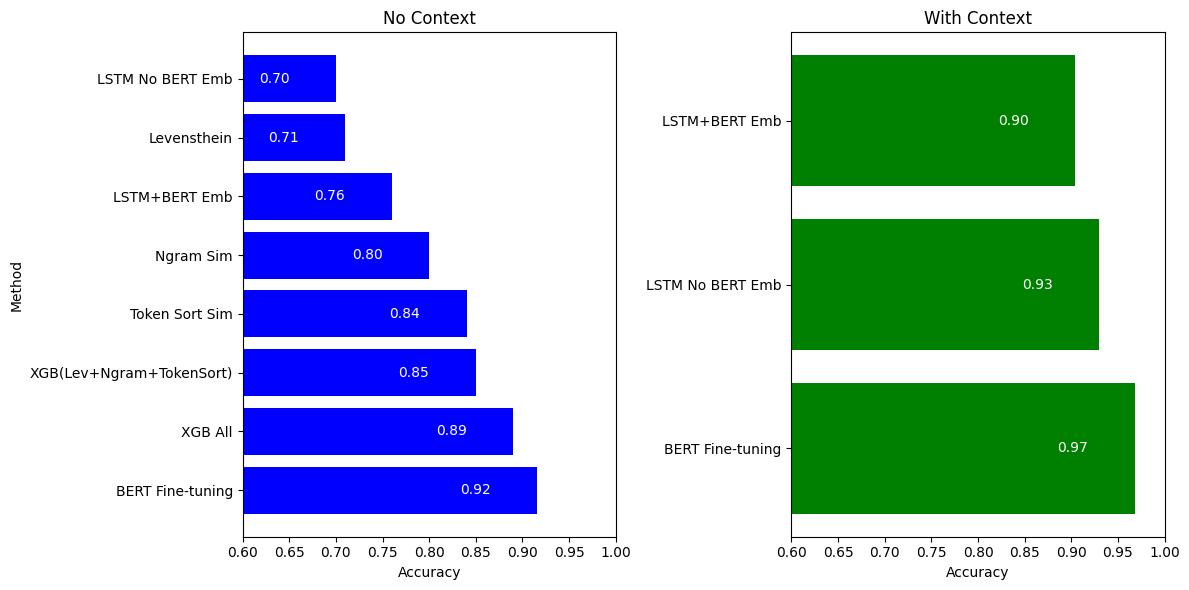

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Data for No Context
nc_methods = ['Levensthein', 'Ngram Sim', 'Token Sort Sim', 'XGB(Lev+Ngram+TokenSort)', 'XGB All', 'LSTM+BERT Emb', 'LSTM No BERT Emb', 'BERT Fine-tuning']
nc_scores = [0.71, 0.80, 0.84, 0.85, 0.89, 0.76, 0.70, 0.916]

# Data for With Context
c_methods = ['LSTM+BERT Emb', 'LSTM No BERT Emb', 'BERT Fine-tuning']
c_scores = [0.904, 0.93, 0.968]

# Sort the data by scores in descending order for both No Context and With Context
nc_sorted = sorted(zip(nc_scores, nc_methods), reverse=True)
c_sorted = sorted(zip(c_scores, c_methods), reverse=True)

# Unzip the sorted data
nc_scores_sorted, nc_methods_sorted = zip(*nc_sorted)
c_scores_sorted, c_methods_sorted = zip(*c_sorted)

# Set up the figure and axes for two side-by-side bar charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Bar chart for No Context with sorted values
bars1 = ax1.barh(nc_methods_sorted, nc_scores_sorted, color='blue')
ax1.set_title('No Context')
ax1.set_xlabel('Accuracy')
ax1.set_xlim(0.6, 1)
ax1.set_ylabel('Method')

# Add labels to bars in No Context chart
for bar in bars1:
    width = bar.get_width()
    ax1.text(width - 0.05, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center', ha='right', color='white')

# Bar chart for With Context with sorted values
bars2 = ax2.barh(c_methods_sorted, c_scores_sorted, color='green')
ax2.set_title('With Context')
ax2.set_xlabel('Accuracy')
ax2.set_xlim(0.6, 1)

# Add labels to bars in With Context chart
for bar in bars2:
    width = bar.get_width()
    ax2.text(width - 0.05, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center', ha='right', color='white')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

Coba cek similarity score